# Perfs

## Import de la recherche

In [1]:
from typing import Callable, List, Dict
from index import Document, Corpus, InvertedIndex, Query

import pandas, os, re

DATA_FOLDER = os.path.join(os.getcwd(), "output")
INDEX_OUTPUT_DIR = os.path.join(DATA_FOLDER, "index_files")

XML_INITIAL_FILE = os.path.join(DATA_FOLDER, "corpus_initial.xml")
STEMMED_REPLACEMENTS = os.path.join(DATA_FOLDER, "stemmed_replacement.tsv")
LEMMATIZED_REPLACEMENTS = os.path.join(DATA_FOLDER, "lemmatized_replacement.tsv")

STORAGE_TAGS = {"Corpus": "corpus", "documents": "bulletins", "Document": "bulletin", "Image": "image"}

### Reconstruction des Index

In [2]:
# 1. Charge le Corpus
with open(XML_INITIAL_FILE, "r", encoding="utf-8") as f:
    CORPUS = Corpus.model_validate_xml(f.read(), tags=STORAGE_TAGS)

# 2. Charge l'Index inversé par zone et par type de tokenisation
INDEXES: Dict[str, Dict[str, InvertedIndex]] = {}
for index_type in ["lemmatized", "stemmed"]:
    INDEXES[index_type] = {}
    for zone in ["texte", "legendes", "titre"]:
        INDEXES[index_type][zone] = InvertedIndex.from_dataframe(pandas.read_csv(os.path.join(INDEX_OUTPUT_DIR, f"index_{zone}_{index_type}.xml"), sep="\t", encoding="utf-8"))

C:\Users\ongki\AppData\Local\Temp\ipykernel_18648\2807305975.py:10: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,2

### Chargement des fichiers de substitutions pour le processing des mots clés

In [3]:
lemma_substitutions = pandas.read_csv(LEMMATIZED_REPLACEMENTS, sep="\t", encoding="utf-8", index_col=0, header=None).to_dict()[1]
stem_substitutions = pandas.read_csv(STEMMED_REPLACEMENTS, sep="\t", encoding="utf-8", index_col=0, header=None).to_dict()[1]

### Fonctions d'evaluation

In [8]:
from index import spacy_lemmatize, snowball_stem, correct_tokens
spacy_lemmatize("trousseaux")[0]
snowball_stem("trousseaux")[0]

lexicon = set(lemma_substitutions.keys())
def correct(inp: str) -> str:
    tokens = correct_tokens(tokens=[inp], lexicon=lexicon)
    return tokens[0][0] if tokens[0][0] else inp

def correct_and_lemmatize(inp: str) -> str:
    token = correct(inp)
    return lemma_substitutions.get(token, None) or spacy_lemmatize(token)[0]

correct_and_lemmatize("santté")

'santé'

In [ ]:

STANDARDIZE: Callable[[str], str] = lambda x: re.sub(r"[^\w\s]", "", re.sub(r"'", " ", x.strip().lower()))
TOKENIZE_LEMMATIZE: Callable[[List[str]], List[str]] = lambda x: lemma_substitutions.get(STANDARDIZE(x), None) or correct_and_lemmatize(STANDARDIZE(x))
TOKENIZE_STEM: Callable[[List[str]], List[str]] = lambda x: stem_substitutions.get(STANDARDIZE(x), None) or snowball_stem(STANDARDIZE(x))[0]

def APPLY(q: Query, func: callable, fields: List[str]) -> Query:
    """Apply a function to the tokens in specified fields of a Query object."""
    for field in fields:
        setattr(q, field, [func(token) for token in getattr(q, field)] if isinstance(getattr(q, field), list) else func(getattr(q, field)))
    return q

def recherche_lemma_ia(query: str) -> List[Document]:
    q = Query.llm_build(query)
    APPLY(q, TOKENIZE_LEMMATIZE, ["content_terms", "negated_content_terms", "title_terms"])
    APPLY(q, STANDARDIZE, ["rubric_terms", "negated_rubric_terms"])
    return q.search(documents={d.document_id: d for d in CORPUS.documents}, index=INDEXES["lemmatized"])

def recherche_stem_ia(query: str) -> List[Document]:
    q = Query.llm_build(query)
    APPLY(q, TOKENIZE_STEM, ["content_terms", "negated_content_terms", "title_terms"])
    APPLY(q, STANDARDIZE, ["rubric_terms", "negated_rubric_terms"])
    return q.search(documents={d.document_id: d for d in CORPUS.documents}, index=INDEXES["stemmed"])

def recherche_lemma_regex(query: str) -> List[Document]:
    q = Query.build(query)
    APPLY(q, TOKENIZE_LEMMATIZE, ["content_terms", "negated_content_terms", "title_terms"])
    APPLY(q, STANDARDIZE, ["rubric_terms", "negated_rubric_terms"])
    return q.search(documents={d.document_id: d for d in CORPUS.documents}, index=INDEXES["lemmatized"])

def recherche_stem_regex(query: str) -> List[Document]:
    q = Query.build(query)
    APPLY(q, TOKENIZE_STEM, ["content_terms", "negated_content_terms", "title_terms"])
    APPLY(q, STANDARDIZE, ["rubric_terms", "negated_rubric_terms"])
    return q.search(documents={d.document_id: d for d in CORPUS.documents}, index=INDEXES["stemmed"])


In [6]:
res = recherche_lemma_ia("montre moi les articles qui parlent d'environnement, minimum depuis juillet 2011 et qui nest pas dans la rubrique Focus")
res[0] if res else []

Document(fichier='76511.htm', numero='292', date=datetime.datetime(2014, 8, 6, 0, 0), rubrique='Au coeur des régions', titre='Equilibre entre radicaux libres et antioxydants : les promesses de la "logique du vivant"', auteur='ADIT - Jean-François Desessard - email : jfd@adit.fr', contact='Lara Spiral - Michel Prost - email : michelprost.spiral@wanadoo.fr', texte='C\'est le 3 avril dernier, à Dijon, lors de la première journée de la 9ème édition du Congrès Goût Nutrition Santé, que Lara Spiral, un laboratoire de recherche dijonnais, et MegaMix, une entreprise russe leader sur le marché des additifs destinés à l\'alimentation des animaux de la ferme et l\'aviculture, ont signé un accord de coopération. Un motif de satisfaction d\'autant plus grand pour Michel Prost, fondateur et Président Directeur Général de cette PME, que l\'entreprise russe est intéressée plus particulièrement par son approche de la "logique du vivant", une théorie qui s\'inscrit pleinement dans la stratégie autour de

In [7]:
recherche_stem_regex("Quels sont les articles parus entre le 3 mars 2013 et le 4 mai 2013 évoquant les Etats-Unis ?")

[Document(fichier='72932.htm', numero='280', date=datetime.datetime(2013, 4, 30, 0, 0), rubrique='Focus', titre="Nalini Anantharaman ou le plaisir d'explorer des domaines inconnus des mathématiques", auteur='ADIT - Jean-François Desessard - email : jfd@adit.fr', contact='Nalini Anantharaman - email : Nalini.Anantharaman@math.u-psud.fr', texte='L\'été dernier, lors du traditionnel International Congress on Mathematical Physics (ICMP), elle a reçu le prestigieux prix Henri Poincaré qu\'elle a partagé avec trois autres lauréats, dont une autre mathématicienne française. L\'année précédente, deux autres prix très réputés, le prix Raphaël Salem, du nom d\'un mathématicien grec du XXème siècle, et le prix Jacques Herbrand, décerné par l\'Académie des sciences, lui avaient été attribués. En février dernier, c\'est le CNRS qui lui a décerné sa Médaille d\'argent. Entre temps, cette mathématicienne trentenaire qu\'est Nalini Anantharaman, mariée à un mathématicien et maman de deux jeunes enfant

In [8]:
Query.llm_build("Quels sont les articles parus entre le 3 mars 2013 et le 4 mai 2013 évoquant les Etats-Unis ?")

Query(content_terms=['Etats-Unis'], content_operator='AND', rubric_terms=[], rubric_operator='OR', negated_content_terms=[], negated_rubric_terms=[], date_start=datetime.datetime(2013, 3, 3, 0, 0, tzinfo=TzInfo(UTC)), date_end=datetime.datetime(2013, 5, 4, 23, 59, 59, 999000, tzinfo=TzInfo(UTC)), excluded_date_periods=[], title_terms=[], title_operator='AND', has_image=False, target_info='articles')

In [9]:
Query.build("Quels sont les articles parus entre le 3 mars 2013 et le 4 mai 2013 évoquant les Etats-Unis ?")

Query(content_terms=['etats-unis'], content_operator='AND', rubric_terms=[], rubric_operator=None, negated_content_terms=[], negated_rubric_terms=[], date_start=datetime.datetime(2013, 3, 3, 0, 0, tzinfo=datetime.timezone.utc), date_end=datetime.datetime(2013, 5, 4, 23, 59, 59, 999999, tzinfo=datetime.timezone.utc), excluded_date_periods=[], title_terms=[], title_operator=None, has_image=False, target_info='articles')

## Evaluation des Performances

In [10]:
TRUTH: Dict[str, List[Document]] = {
    "Quels sont les articles parus entre le 3 mars 2013 et le 4 mai 2013 évoquant les Etats-Unis ?": ["72932.htm"],
    "Je veux les articles de 2014 et de la rubrique Focus et parlant de la santé": ["75458.htm", "75459.htm", "76507.htm"],
    "Je souhaite les rubriques des articles parlant de nutrition ou de vins.": ["Focus", "Au coeur des régions", "Du côté des pôles", "Actualité Innovation", "A lire"], 
}

In [11]:
var = [
  {
    "nom_test": "test_etats_unis_date_range",
    "requete_utilisateur": "Quels sont les articles parus entre le 3 mars 2013 et le 4 mai 2013 évoquant les etatsunis ?",
    "resultat_attendu": {
      "type_resultat": "articles",
      "valeurs": ["72932.htm"]
    }
  },
  {
    "nom_test": "test_annee_rubrique_contenu",
    "requete_utilisateur": "Je veux les articles de 2014 et de la rubrique Focus et parlant de la santé",
    "resultat_attendu": {
      "type_resultat": "articles",
      "valeurs": ["75458.htm", "75459.htm", "76507.htm"]
    }
  },
  {
    "nom_test": "test_rubriques_nutrition_vins",
    "requete_utilisateur": "Je souhaite les rubriques des articles parlant de nutrition ou de vin.",
    "resultat_attendu": {
      "type_resultat": "rubriques",
      "valeurs": [
        "Actualité Innovation",
        "Actualités Innovations",
        "Au coeur des régions",
        "Du côté des pôles",
        "Evénement",
        "Focus"
      ]
    }
  },
  {
    "nom_test": "test_serious_game_realite_virtuelle_aucun",
    "requete_utilisateur": "Article traitant des Serious Game et de la réalité virtuelle.",
    "resultat_attendu": {
      "type_resultat": "articles",
      "valeurs": []
    }
  },
  {
    "nom_test": "test_image_titre_croissance",
    "requete_utilisateur": "Je voudrais les articles avec des images dont le titre contient le mot croissance.",
    "resultat_attendu": {
      "type_resultat": "articles",
      "valeurs": ["68390.htm"]
    }
  },
  {
    "nom_test": "test_cnrs_grandes_ecoles_sauf_centrale",
    "requete_utilisateur": "Liste des articles qui parlent soit du cnr, soit des grand ecole, mais pas de centrale pari.",
    "resultat_attendu": {
      "type_resultat": "articles",
      "valeurs": [
        "67068.htm", "67071.htm", "67383.htm", "67385.htm", "67387.htm",
        "67390.htm", "67391.htm", "67556.htm", "67558.htm", "67795.htm",
        "67799.htm", "67800.htm", "67802.htm", "67937.htm", "67939.htm",
        "67943.htm", "67944.htm", "67945.htm", "68276.htm", "68277.htm",
        "68278.htm", "68280.htm", "68281.htm", "68384.htm", "68385.htm",
        "68388.htm", "68389.htm", "68390.htm", "68393.htm", "68638.htm",
        "68639.htm", "68641.htm", "68642.htm", "68644.htm", "68645.htm",
        "68646.htm", "68883.htm", "68886.htm", "68887.htm", "68889.htm",
        "69177.htm", "69178.htm", "69180.htm", "69181.htm", "69182.htm",
        "69183.htm", "69184.htm", "69185.htm", "69186.htm", "69533.htm",
        "69539.htm", "69540.htm", "69541.htm", "69542.htm", "69814.htm",
        "69816.htm", "69819.htm", "69820.htm", "70161.htm", "70163.htm",
        "70168.htm", "70420.htm", "70422.htm", "70423.htm", "70424.htm",
        "70425.htm", "70743.htm", "70744.htm", "70745.htm", "70747.htm",
        "70748.htm", "70914.htm", "70916.htm", "70922.htm", "70923.htm",
        "71358.htm", "71361.htm", "71362.htm", "71363.htm", "71612.htm",
        "71615.htm", "71835.htm", "71838.htm", "71841.htm", "71843.htm",
        "72114.htm", "72119.htm", "72121.htm", "72397.htm", "72398.htm",
        "72632.htm", "72633.htm", "72634.htm", "72635.htm", "72637.htm",
        "72932.htm", "72934.htm", "72939.htm", "72940.htm", "73182.htm",
        "73183.htm", "73185.htm", "73186.htm", "73188.htm", "73189.htm",
        "73190.htm", "73431.htm", "73434.htm", "73436.htm", "73683.htm",
        "73685.htm", "73687.htm", "73688.htm", "73877.htm", "73882.htm",
        "73883.htm", "74170.htm", "74173.htm", "74175.htm", "74450.htm",
        "74452.htm", "74455.htm", "74750.htm", "74752.htm", "75063.htm",
        "75065.htm", "75066.htm", "75067.htm", "75070.htm", "75071.htm",
        "75457.htm", "75458.htm", "75460.htm", "75463.htm", "75464.htm",
        "75790.htm", "75791.htm", "75794.htm", "75796.htm", "76208.htm",
        "76210.htm", "76513.htm"
      ]
    }
  },
  {
    "nom_test": "test_rubrique_focus_actualites_chercheurs_paris",
    "requete_utilisateur": "Je souhaites avoir tout les articles donc la rubrique est focus ou Actualités Innovations et qui contiennent les mots chercheur et pari.",
    "resultat_attendu": {
      "type_resultat": "articles",
      "valeurs": [
        "67068.htm", "67795.htm", "68638.htm", "69178.htm", "70421.htm",
        "70422.htm", "70424.htm", "70914.htm", "71612.htm", "71835.htm",
        "71837.htm", "71841.htm", "72113.htm", "72393.htm", "72932.htm",
        "72933.htm", "73184.htm", "73431.htm", "75063.htm", "75065.htm",
        "75788.htm"
      ]
    }
  },
  {
    "nom_test": "test_date_1dec2012_rubrique_actualites_innovations_rien",
    "requete_utilisateur": "Je voudrais les articles qui datent du 1 décembre 2012 et dont la rubrique est Actualités Innovations.",
    "resultat_attendu": {
      "type_resultat": "articles",
      "valeurs": []
    }
  },
  {
    "nom_test": "test_entre_2012_2013_sauf_juin",
    "requete_utilisateur": "Je voudrais tous les bulletins écrits entre 2012 et 2013 mais pas au mois de juin",
    "resultat_attendu": {
      "type_resultat": "articles",
      "valeurs": [
        "68881.htm", "68882.htm", "68883.htm", "68884.htm", "68885.htm",
        "68886.htm", "68887.htm", "68888.htm", "68889.htm", "69177.htm",
        "69178.htm", "69179.htm", "69180.htm", "69181.htm", "69182.htm",
        "69183.htm", "69184.htm", "69185.htm", "69186.htm", "69533.htm",
        "69534.htm", "69535.htm", "69536.htm", "69537.htm", "69538.htm",
        "69539.htm", "69540.htm", "69541.htm", "69542.htm", "69543.htm",
        "69811.htm", "69812.htm", "69813.htm", "69814.htm", "69815.htm",
        "69816.htm", "69817.htm", "69818.htm", "69819.htm", "69820.htm",
        "69821.htm", "70161.htm", "70162.htm", "70163.htm", "70164.htm",
        "70165.htm", "70166.htm", "70167.htm", "70168.htm", "70169.htm",
        "70170.htm", "70743.htm", "70744.htm", "70745.htm", "70746.htm",
        "70747.htm", "70748.htm", "70749.htm", "70751.htm", "70752.htm",
        "70753.htm", "70914.htm", "70915.htm", "70916.htm", "70917.htm",
        "70918.htm", "70919.htm", "70920.htm", "70921.htm", "70922.htm",
        "70923.htm", "71357.htm", "71358.htm", "71359.htm", "71360.htm",
        "71361.htm", "71362.htm", "71363.htm", "71366.htm", "71612.htm",
        "71614.htm", "71615.htm", "71616.htm", "71617.htm", "71618.htm",
        "71619.htm", "71620.htm", "71621.htm", "71835.htm", "71836.htm",
        "71837.htm", "71838.htm", "71839.htm", "71840.htm", "71841.htm",
        "71842.htm", "71843.htm", "71845.htm", "72113.htm", "72114.htm",
        "72115.htm", "72116.htm", "72117.htm", "72118.htm", "72119.htm",
        "72120.htm", "72121.htm", "72122.htm", "72392.htm", "72393.htm",
        "72394.htm", "72395.htm", "72396.htm", "72397.htm", "72398.htm",
        "72399.htm", "72400.htm", "72401.htm", "72629.htm", "72630.htm",
        "72631.htm", "72632.htm", "72633.htm", "72634.htm", "72635.htm",
        "72636.htm", "72637.htm", "72932.htm", "72933.htm", "72934.htm",
        "72935.htm", "72936.htm", "72937.htm", "72938.htm", "72939.htm",
        "72940.htm", "73430.htm", "73431.htm", "73432.htm", "73433.htm",
        "73434.htm", "73435.htm", "73436.htm", "73437.htm", "73438.htm",
        "73683.htm", "73684.htm", "73685.htm", "73686.htm", "73687.htm",
        "73688.htm", "73689.htm", "73690.htm", "73691.htm", "73875.htm",
        "73876.htm", "73877.htm", "73878.htm", "73879.htm", "73880.htm",
        "73881.htm", "73882.htm", "73883.htm", "73884.htm", "74167.htm",
        "74168.htm", "74169.htm", "74170.htm", "74171.htm", "74172.htm",
        "74173.htm", "74174.htm", "74175.htm", "74176.htm", "74449.htm",
        "74450.htm", "74451.htm", "74452.htm", "74453.htm", "74454.htm",
        "74455.htm", "74456.htm", "74457.htm", "74744.htm", "74745.htm",
        "74746.htm", "74747.htm", "74748.htm", "74749.htm", "74750.htm",
        "74751.htm", "74752.htm"
      ]
    }
  },
  {
    "nom_test": "test_changement_climatique_apres_29092011",
    "requete_utilisateur": "Je cherche les articles sur le changement et climatique publiés après 29/09/2011",
    "resultat_attendu": {
      "type_resultat": "articles",
      "valeurs": [
        "67794.htm", "67803.htm", "67939.htm", "68278.htm", "68283.htm",
        "68389.htm", "68645.htm", "68882.htm", "69182.htm", "69533.htm",
        "69535.htm", "69811.htm", "69814.htm", "69816.htm", "69817.htm",
        "70745.htm", "70916.htm", "70920.htm", "71363.htm", "71617.htm",
        "71621.htm", "71837.htm", "71838.htm", "73183.htm", "73434.htm",
        "73688.htm", "73877.htm", "73880.htm", "75458.htm", "75463.htm",
        "76213.htm"
      ]
    }
  }
]

In [12]:
TRUTH = {v["requete_utilisateur"]: v["resultat_attendu"]["valeurs"] for v in var}
TRUTH.keys()

dict_keys(['Quels sont les articles parus entre le 3 mars 2013 et le 4 mai 2013 évoquant les etatsunis ?', 'Je veux les articles de 2014 et de la rubrique Focus et parlant de la santé', 'Je souhaite les rubriques des articles parlant de nutrition ou de vin.', 'Article traitant des Serious Game et de la réalité virtuelle.', 'Je voudrais les articles avec des images dont le titre contient le mot croissance.', 'Liste des articles qui parlent soit du cnr, soit des grand ecole, mais pas de centrale pari.', 'Je souhaites avoir tout les articles donc la rubrique est focus ou Actualités Innovations et qui contiennent les mots chercheur et pari.', 'Je voudrais les articles qui datent du 1 décembre 2012 et dont la rubrique est Actualités Innovations.', 'Je voudrais tous les bulletins écrits entre 2012 et 2013 mais pas au mois de juin', 'Je cherche les articles sur le changement et climatique publiés après 29/09/2011'])

In [13]:
for val in TRUTH.values():
    print(len(val), val)

1 ['72932.htm']
3 ['75458.htm', '75459.htm', '76507.htm']
6 ['Actualité Innovation', 'Actualités Innovations', 'Au coeur des régions', 'Du côté des pôles', 'Evénement', 'Focus']
0 []
1 ['68390.htm']
142 ['67068.htm', '67071.htm', '67383.htm', '67385.htm', '67387.htm', '67390.htm', '67391.htm', '67556.htm', '67558.htm', '67795.htm', '67799.htm', '67800.htm', '67802.htm', '67937.htm', '67939.htm', '67943.htm', '67944.htm', '67945.htm', '68276.htm', '68277.htm', '68278.htm', '68280.htm', '68281.htm', '68384.htm', '68385.htm', '68388.htm', '68389.htm', '68390.htm', '68393.htm', '68638.htm', '68639.htm', '68641.htm', '68642.htm', '68644.htm', '68645.htm', '68646.htm', '68883.htm', '68886.htm', '68887.htm', '68889.htm', '69177.htm', '69178.htm', '69180.htm', '69181.htm', '69182.htm', '69183.htm', '69184.htm', '69185.htm', '69186.htm', '69533.htm', '69539.htm', '69540.htm', '69541.htm', '69542.htm', '69814.htm', '69816.htm', '69819.htm', '69820.htm', '70161.htm', '70163.htm', '70168.htm', '70

### Calcul des métriques

In [14]:

import pandas, datetime

CASES = ["ia_lemma", "ia_stem", "reg_lemma", "reg_stem"]
EVALUATORS = [recherche_lemma_ia, recherche_stem_ia, recherche_lemma_regex, recherche_stem_regex]

DATA: Dict[str, pandas.DataFrame] = {name: pandas.DataFrame(columns=["Recall", "Precision", "Delay", "Hint"]) for name in CASES}
for layer, search in zip(CASES, EVALUATORS):

    for query, truth in TRUTH.items():
        
        start = datetime.datetime.now()
        results = [(d.document_id if isinstance(d, Document) else d) for d in (search(query) or [])]

        row = {
            "Recall":    len(set(results) & set(truth)) / len(truth) if len(truth) > 0 else 0.0,
            "Precision": len(set(results) & set(truth)) / len(results) if len(results) > 0 else 0.0,
            "Size":      len(results),
            "Delay":     (datetime.datetime.now() - start).total_seconds(),
            "Hint":      query,
        }

        DATA[layer] = pandas.concat([DATA[layer], pandas.DataFrame([row])], ignore_index=True)

DATA["ia_lemma"]

C:\Users\ongki\AppData\Local\Temp\ipykernel_22196\249936839.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  DATA[layer] = pandas.concat([DATA[layer], pandas.DataFrame([row])], ignore_index=True)
C:\Users\ongki\AppData\Local\Temp\ipykernel_22196\249936839.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  DATA[layer] = pandas.concat([DATA[layer], pandas.DataFrame([row])], ignore_index=True)
C:\Users\ongki\AppData\Local\Temp\ipykernel_22196\249936839.py:22: FutureWarning: The behavior of Da

,Recall,Precision,Delay,Hint,Size
0,0.000000,0.00000,3.889906,Quels sont les articles parus entre le 3 mars ...,0.0
1,1.000000,1.00000,2.935644,Je veux les articles de 2014 et de la rubrique...,3.0
2,1.000000,1.00000,2.409687,Je souhaite les rubriques des articles parlant...,6.0
3,0.000000,0.00000,4.305643,Article traitant des Serious Game et de la réa...,0.0
4,1.000000,1.00000,2.274949,Je voudrais les articles avec des images dont ...,1.0
5,0.654930,0.57764,4.529185,"Liste des articles qui parlent soit du cnr, so...",161.0
6,0.523810,1.00000,2.537432,Je souhaites avoir tout les articles donc la r...,11.0
7,0.000000,0.00000,3.436420,Je voudrais les articles qui datent du 1 décem...,0.0
8,1.000000,1.00000,3.235061,Je voudrais tous les bulletins écrits entre 20...,192.0
9,0.580645,0.62069,4.229180,Je cherche les articles sur le changement et c...,29.0


In [15]:
DATA["ia_stem"]

,Recall,Precision,Delay,Hint,Size
0,1.000000,1.000000,3.113390,Quels sont les articles parus entre le 3 mars ...,1.0
1,1.000000,1.000000,2.966846,Je veux les articles de 2014 et de la rubrique...,3.0
2,1.000000,1.000000,2.471515,Je souhaite les rubriques des articles parlant...,6.0
3,0.000000,0.000000,2.497869,Article traitant des Serious Game et de la réa...,0.0
4,1.000000,1.000000,2.433107,Je voudrais les articles avec des images dont ...,1.0
5,0.647887,0.593548,2.636922,"Liste des articles qui parlent soit du cnr, so...",155.0
6,0.000000,0.000000,2.606197,Je souhaites avoir tout les articles donc la r...,0.0
7,0.000000,0.000000,3.002051,Je voudrais les articles qui datent du 1 décem...,0.0
8,1.000000,1.000000,3.120701,Je voudrais tous les bulletins écrits entre 20...,192.0
9,0.612903,0.527778,2.673057,Je cherche les articles sur le changement et c...,36.0


In [16]:
# moyenne par colonne
for name, df_ in DATA.items():
    print(
        df_.mean(numeric_only=True).to_frame().T
    )

     Recall  Precision     Delay  Size
0  0.575938   0.619833  3.378311  40.3
     Recall  Precision     Delay  Size
0  0.626079   0.612133  2.752165  39.4
    Recall  Precision    Delay  Size
0  0.68239   0.757764  0.37381  39.5
     Recall  Precision     Delay  Size
0  0.632531   0.659355  0.002264  37.9


### Visualisation

In [17]:
df = pandas.DataFrame(columns=["Delay", "Recall", "Precision", "Model"])
for model, data in DATA.items():
    df = pandas.concat([
        df,
        data[["Delay", "Recall", "Precision"]].assign(Model=model)
    ], ignore_index=True)
df.head(2)

C:\Users\ongki\AppData\Local\Temp\ipykernel_22196\618777212.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pandas.concat([


,Delay,Recall,Precision,Model
0,3.889906,0.0,0.0,ia_lemma
1,2.935644,1.0,1.0,ia_lemma


<Axes: xlabel='Model', ylabel='Delay'>

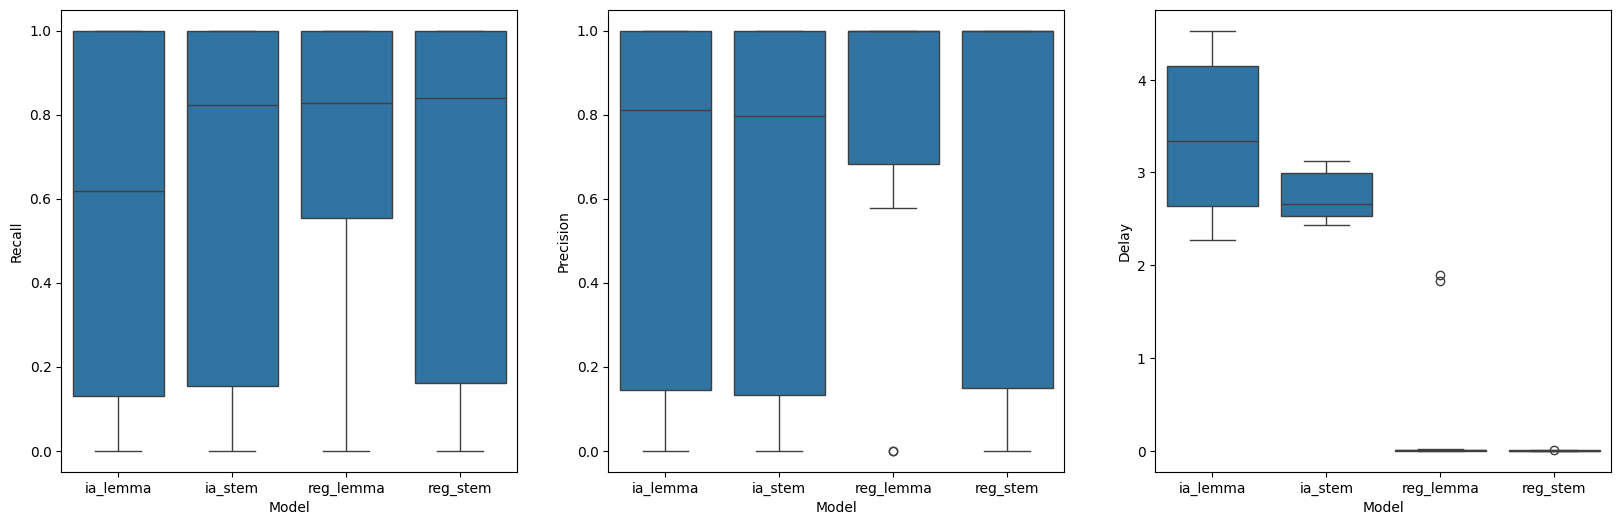

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

sns.boxplot(x="Model", y="Recall", data=df, ax=axs[0])
sns.boxplot(x="Model", y="Precision", data=df, ax=axs[1])
sns.boxplot(x="Model", y="Delay", data=df, ax=axs[2])

In [ ]:
lemmes_uniques = set(lemma_substitutions.values())
stemmes_uniques = set(stem_substitutions.values())

len(lemmes_uniques), len(stemmes_uniques)

(10830, 9220)

In [ ]:
def count_shared(substitutions: Dict[str, str]) -> Dict[str, int]:
    """Calcule le nombre de mots différents qui partagent le même stem / lemma."""
    counts = {}
    for word, stem in substitutions.items():
        if stem not in counts:
            counts[stem] = set()
        counts[stem].add(word)
    
    return {stem: len(words) for stem, words in counts.items()}

shared_stems = sorted(count_shared(stem_substitutions).items(), key=lambda x: x[1], reverse=True)
shared_lemmas = sorted(count_shared(lemma_substitutions).items(), key=lambda x: x[1], reverse=True)

Text(0, 0.5, 'Nombre de stems/lemmes')

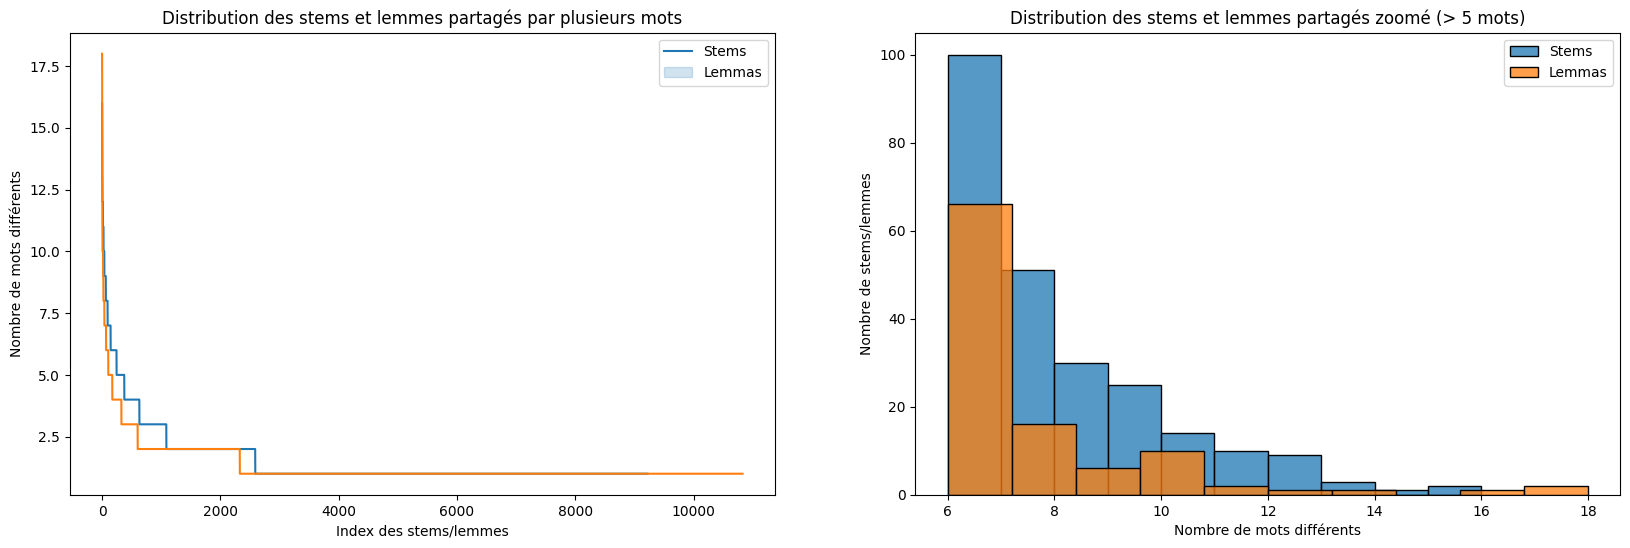

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# plot a histogram of the number of sizes of shared stems and lemmas
sns.lineplot(x=list(range(len(shared_stems))), y=[x[1] for x in shared_stems], ax=axs[0])
sns.lineplot(x=list(range(len(shared_lemmas))), y=[x[1] for x in shared_lemmas], ax=axs[0])
# sns.histplot([x[1] for x in shared_stems if x[1]], bins=20, ax=axs[0])
# sns.histplot([x[1] for x in shared_lemmas if x[1]], bins=20, ax=axs[0])
sns.histplot([x[1] for x in shared_stems if x[1] > 5], bins=10, ax=axs[1])
sns.histplot([x[1] for x in shared_lemmas if x[1] > 5], bins=10, ax=axs[1])

# titres
axs[0].set_title("Distribution des stems et lemmes partagés par plusieurs mots")
axs[1].set_title("Distribution des stems et lemmes partagés zoomé (> 5 mots)")

# legendes
axs[0].legend(["Stems", "Lemmas"])
axs[1].legend(["Stems", "Lemmas"])

# axes
axs[0].set_xlabel("Index des stems/lemmes")
axs[0].set_ylabel("Nombre de mots différents")
axs[1].set_xlabel("Nombre de mots différents")
axs[1].set_ylabel("Nombre de stems/lemmes")

Les lemmes sont uniformément plus "uniques", moins de mots partagent les mêmes lemmes à travers presque toute la distribution que ne partagent la même stem.
Un index par stem confondra davantage la query qu'un index par lemmes.
On peut noter que les mots qui partagent le plus de lemmes en ont plus que ceux qui partagent le plus de stems.

Combien de racines sont répétées ?

In [ ]:
counts_stems = {}
for stem, count in shared_stems:
    if count not in counts_stems:
        counts_stems[count] = 0
    counts_stems[count] += 1
    
counts_lemmas = {}
for lemma, count in shared_lemmas:
    if count not in counts_lemmas:
        counts_lemmas[count] = 0
    counts_lemmas[count] += 1
    
counts_stems[1] / sum(counts_stems.values()), counts_lemmas[1] / sum(counts_lemmas.values())
# (counts_stems[1] + counts_stems[2]) / sum(counts_stems.values()), (counts_lemmas[1] + counts_lemmas[2]) / sum(counts_lemmas.values())

(0.7190889370932755, 0.784949215143121)

72% des stems sont uniques, 78% des lemmes sont uniques (confirme l'observation par le graphique précédent)

88% des stems sont uniques ou partagés par 2 mots, 94% des lemmes sont uniques ou partagés par 2 mots

Text(0, 0.5, 'Nombre de mots différents')

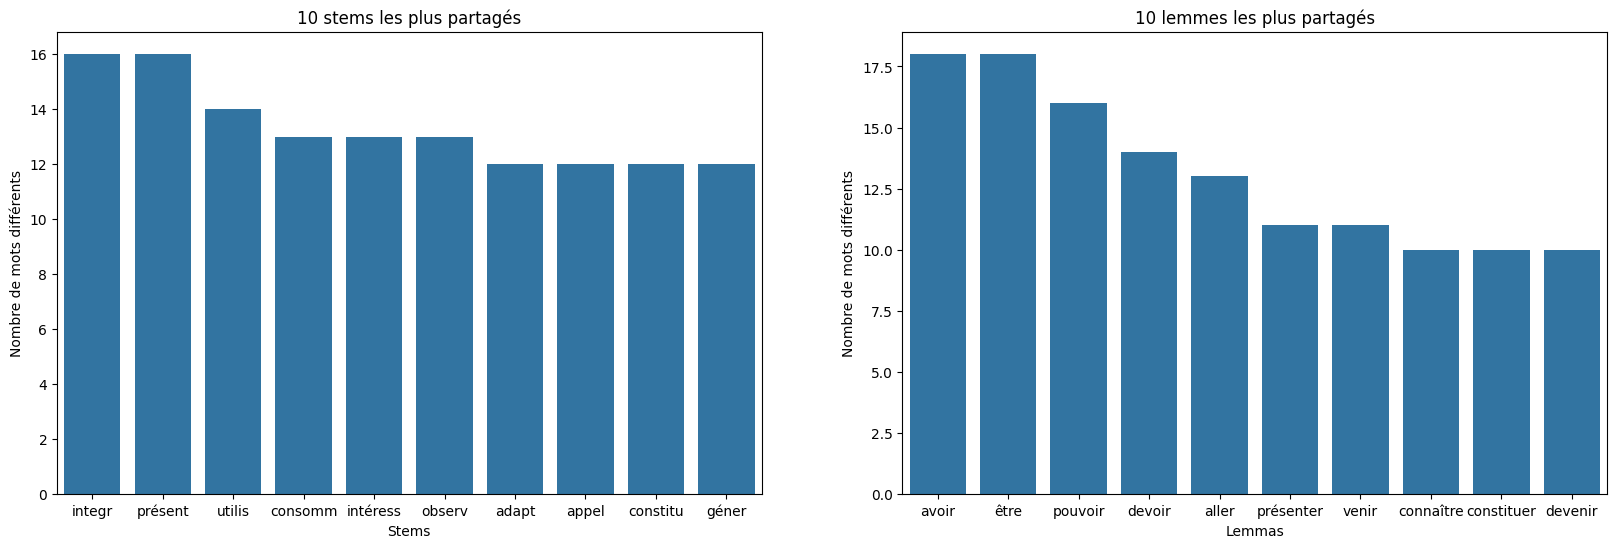

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.barplot(x=[x[0] for x in shared_stems[:10]], y=[x[1] for x in shared_stems[:10]], ax=axs[0])
sns.barplot(x=[x[0] for x in shared_lemmas[:10]], y=[x[1] for x in shared_lemmas[:10]], ax=axs[1])

# titre
axs[0].set_title("10 stems les plus partagés")
axs[1].set_title("10 lemmes les plus partagés")
# axes
axs[0].set_xlabel("Stems")
axs[1].set_xlabel("Lemmas")
axs[0].set_ylabel("Nombre de mots différents")
axs[1].set_ylabel("Nombre de mots différents")

Les lemmes les plus denses (mots associés) sont les verbes, et ils le sont plus que les stems les plus denses
Les mots stemmés les plus denses sont les mots qui présentent un préfix courant en français (integr) engendre beaucoup de mots.

Les lemmes confondent les différentes flexions d'un verbe, tandis que les stems confondent plutôt les mots avec le même préfixe.
Intuitivement, il semble plus pertinent d'ignorer les formes d'un verbe, et risqué d'ignorer différents mots qui partagent "observ" par exemple.

In [ ]:
from index import spacy_lemmatize, snowball_stem

for word in ("trousseaux", "environnement", "environ", "expéridiraient", "expédier", "expédition", "expédions", "décomposaient", "décomposition"):
    print(f"{word} -> {spacy_lemmatize(word)[0]} / {snowball_stem(word)[0]}")

trousseaux -> trousseau / trousseau
environnement -> environnement / environ
environ -> environ / environ
expéridiraient -> expéridiraier / expérid
expédier -> expédier / expédi
expédition -> expédition / expédit
expédions -> expédier / exped
décomposaient -> décomposer / décompos
décomposition -> décomposition / décomposit


Les stems mélangent "environ" et "environnement" alors que ce sont des mots très différents. La lemmatisation distingue les deux.
Expédier et "expédions" deux formes du même verbe sont différenciés par les stems alors que les lemmes les confondent, même formes d'un même verbe (plus pertinent)
Stems et Lemmes s'accordent sinon sur de nombreux exemples, en particulier les noms comme "trousseau" pour lesquels ils parviennent à simplifier les pluriels.
